In [8]:
%load_ext autoreload
%autoreload 2

import das_package as dp
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import scipy.signal as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Downloading Raw Files

In [2]:
interrogator = "Optasense"     #Optasense or Silixa
ship_number = 1
folder = f"Data/Raw/Ship{ship_number}"
results_folder = f"{folder}/results" 
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
url = "http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5"
first_file_time = dp.find_time_url(url, interrogator)
file_timing_length = 60
minutes = 5
n = int(minutes*60/file_timing_length)
all_filenames = dp.dl_das_files(folder, url, first_file_time, file_timing_length, n)
filenames = sorted([file for file in all_filenames if file != f"{folder}\\results"])
print(filenames)

Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5
['Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5']


# Loading Raw Data

In [3]:
if interrogator == 'Optasense':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.optasense(filenames)

elif interrogator == 'Silixa':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.silixa(filenames)


# Downsample factors and channel chunking size
if fs == 1000:
    factor_channels = 2
    factor_time = 5
    ch_chunk_size = 500
elif fs == 500:
    factor_channels = 2
    factor_time = 2
    ch_chunk_size = 700
elif fs == 200:
    factor_channels = 2
    factor_time = 1
    ch_chunk_size = 1000

The concatenated data shape: (47500, 60000)
The first value in "RawDataTime" is 1635902414834000 which is the timestamp of the first sample in microseconds.
This equates to the date and time 2021-11-03 01:20:14.834000
the time step is equal to =  5000.0 microsecond

sampling rate in Hz =  200.0
channel spacing in m =  2.0419047
number of channels =  47500
number of samples in each channel =  60000
gauge length in m =  51.04762


# Converting Raw Data to AI-Ready Data

In [4]:
distance = [20000, 25000]
if dx<2:
    chint = 1
elif dx>=2:
    chint = 1                        
duration = [0, int(ns/fs)]            #in second1
tint = 1                         #time interval (sample)


#Converting selected distance from meter to channels
channels = [int(distance[0]/dx), int(distance[1]/dx), chint]

#Finding number of itterations
itteration = (((channels[1] - channels[0]) / chint)//ch_chunk_size)
print('Number of itterations: ', itteration)


### Raw to strain rate ###
#Determine the first chunck of data
channels_chunk = [int(distance[0]/dx), min(int(distance[0]/dx) + ch_chunk_size*chint , int(distance[1]/dx)), chint]
time_chunk = [int(duration[0]*fs), int(duration[1]*fs), tint]

#Doing analysis for first chunk of data
trace, dist, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
if interrogator == 'Optasense':
    str_rate = dp.strain2strainrate(trace, dt, tint)
elif interrogator == 'Silixa':
    str_rate = trace

#Doing analysis for remained chunks of data
for i in tqdm(range(int(itteration))):

    if (channels_chunk[1] + ch_chunk_size*chint)*dx >= distance[1]:
        channels_chunk = [channels_chunk[1], int(distance[1]/dx), chint]
    else:
        channels_chunk = [channels_chunk[1], channels_chunk[1] + ch_chunk_size*chint, chint]

    if channels_chunk[1] - channels_chunk[0] < 0.1*ch_chunk_size :
        break

    trace, dist_chunk, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
    dist = np.concatenate([dist, dist_chunk])
    if interrogator == 'Optasense':
        str_rate_chunk = dp.strain2strainrate(trace, dt, tint)
    elif interrogator == 'Silixa':
        str_rate_chunk = trace
    str_rate = np.concatenate([str_rate, str_rate_chunk], axis=0)
    del str_rate_chunk, dist_chunk

np.save(f'{folder}/results/str_rate{ship_number}', str_rate)
np.save(f'{folder}/results/time{ship_number}', time)
np.save(f'{folder}/results/dist{ship_number}', dist)

del trace, rawData

if interrogator == 'Optasense':
    files = glob.glob(os.path.join(folder, '*.h5'))
    print(files)
    for file in files:
        os.remove(file)

elif interrogator == 'Silixa':
    files = glob.glob(os.path.join(folder, '*.tdms'))
    print(files)
    for file in files:
        os.remove(file)


Number of itterations:  2.0


100%|██████████| 2/2 [00:04<00:00,  2.14s/it]


['Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5']


## Downsampling the Data

In [6]:
# Downsample the raw data
str_rate_downsampled = block_reduce(str_rate, block_size=(factor_channels, factor_time), func=np.mean)
# Downsample the distance and time domain data
dist_downsampled = block_reduce(dist, block_size=factor_channels, func=np.mean)
time_downsampled = block_reduce(time, block_size=factor_time, func=np.mean)

## Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

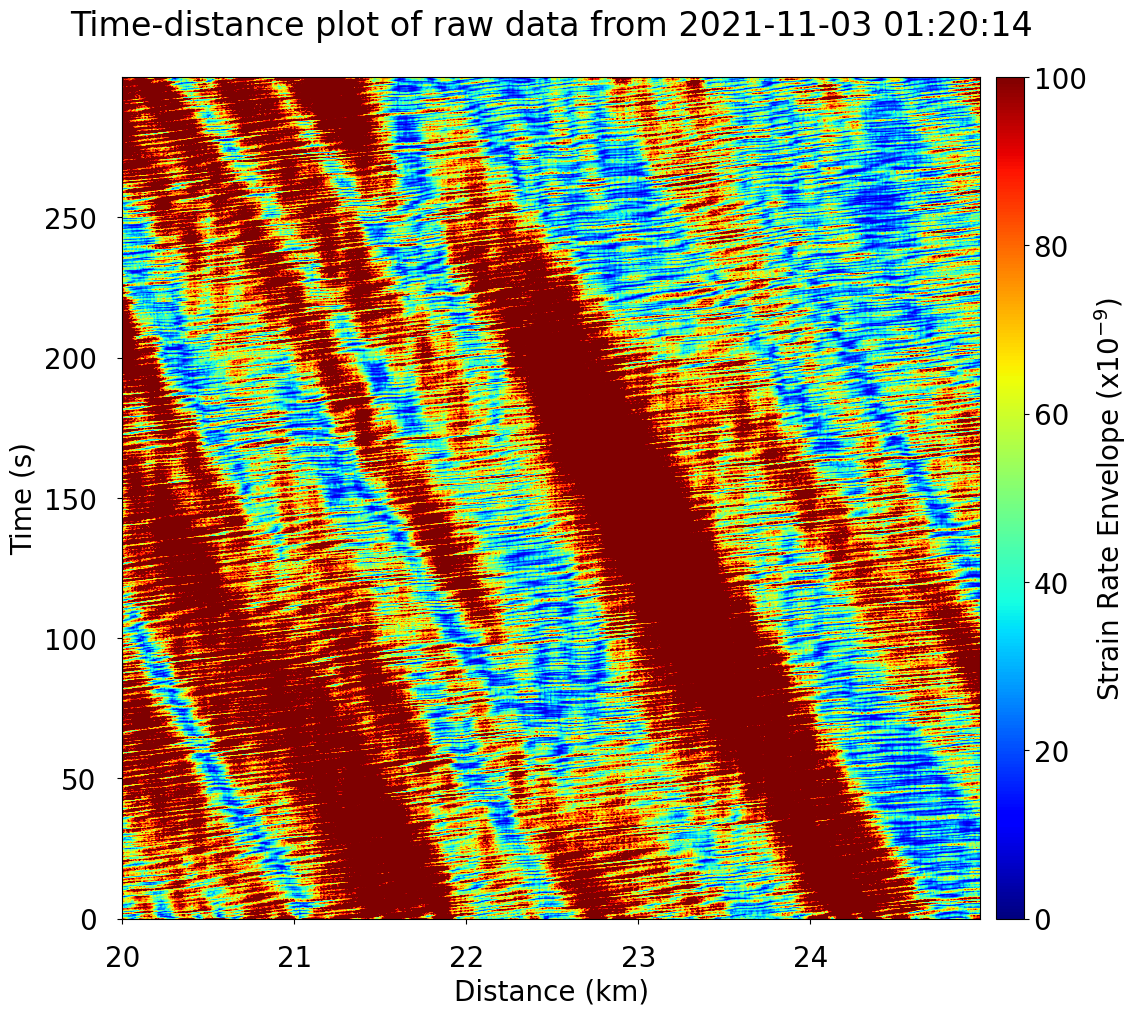

In [9]:
vmax = 100
dp.plot_tx(sp.hilbert(str_rate_downsampled[0:-2,:], axis=1), time_downsampled, dist_downsampled[0:-2], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of raw data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show